# All imports

In [462]:
import pandas as pd
import string
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
from pickle import dump, load
from sklearn.cluster import KMeans
from sklearn.feature_selection import chi2 , SelectKBest, mutual_info_regression
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge, LassoCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, r2_score, make_scorer, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from pmdarima import auto_arima #pip install pmdarima
from statsmodels.tsa.seasonal import seasonal_decompose #pip install statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer
from sklearn import tree

# Opening data

In [463]:
url='https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv'
sales_raw=pd.read_csv(url)

# Data exploration

In [464]:
sales_raw.head(10)

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633
5,2022-09-08 17:10:08.079328,60.081865
6,2022-09-09 17:10:08.079328,68.466704
7,2022-09-10 17:10:08.079328,67.765106
8,2022-09-11 17:10:08.079328,70.512261
9,2022-09-12 17:10:08.079328,74.656453


No missing data:

In [465]:
sales_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    366 non-null    object 
 1   sales   366 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


Exploring some raw summary statistics to get a vague idea of how sales distribute:

In [466]:
sales_raw.describe()

,sales
count,366.000000
mean,524.963968
std,275.089698
min,53.803211
25%,290.186822
50%,520.699468
75%,763.289263
max,1000.482785


Plotting a histogram of sales to check the distribution. This type of graph is helpful to detect whether there are any 'jumps' in the distribution. A major jump could signal outliers

<function matplotlib.pyplot.show(close=None, block=None)>

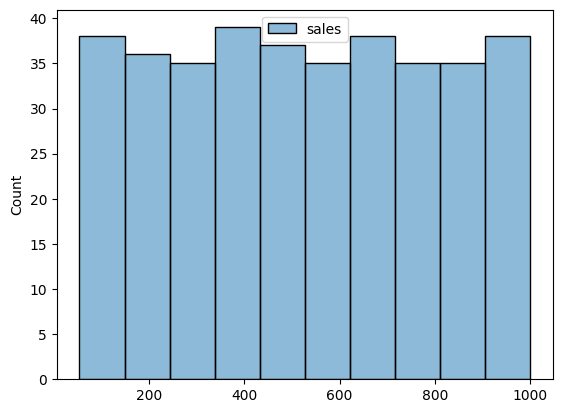

In [467]:
sns.histplot(sales_raw)
plt.show

Seems like sales data is formated as sales for each day of the month, it has entries for about 366 days (e.g., a full year):

In [468]:
sales_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    366 non-null    object 
 1   sales   366 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


# Plotting sales data

In [469]:
#Transforming date variable into date format:
sales_raw.date=pd.to_datetime(sales_raw.date, errors='raise', yearfirst=True)
sales_raw = sales_raw.set_index("date")
#sales_raw.head()



In [470]:
decomp = seasonal_decompose(sales_raw) #setting decomposer of the time series
decomp

trend = decomp.trend #obtaining the sales trend over time

## Studying sales trend over time:

The graph shows an upward trend over time as there is an overlap between sales and trend. The trend follows the upward behaviour of sales data

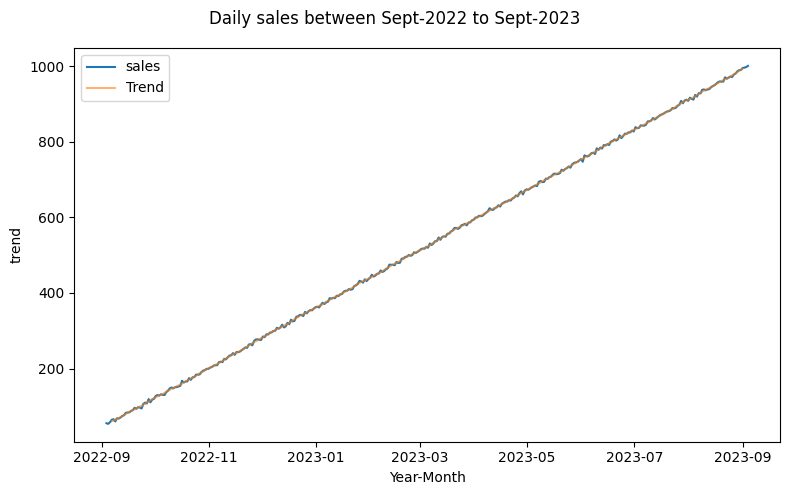

In [471]:
#Creating the plot:
fig, axis= plt.subplots(1,1, figsize =(8,5))

sns.lineplot(sales_raw)

sns.lineplot(trend, alpha=0.6, label='Trend')


axis.set_xlabel('Year-Month')

plt.suptitle('Daily sales between Sept-2022 to Sept-2023')
plt.tight_layout()
plt.show()

## Studying seasonal sales trends

The the seasonal trends graph suggests that there are seasonal (e.g., repetitive patterns) on the sales behaviour over time

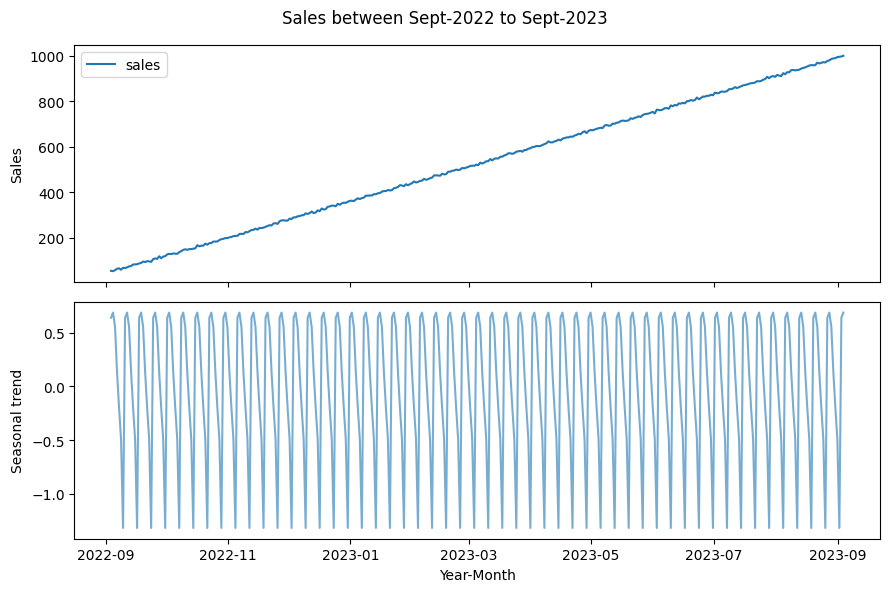

In [472]:
seasonal = decomp.seasonal #obtaining seasonal sales trends

#Creating the plot:
fig, axis= plt.subplots(2,1, figsize =(9,6))

sns.lineplot(sales_raw, ax=axis[0])

sns.lineplot(seasonal, alpha=0.6, ax=axis[1])

axis[0].set_xticklabels('')
axis[0].set_ylabel('Sales')
axis[1].set_ylabel('Seasonal trend')

axis[0].set_xlabel('')
axis[1].set_xlabel('Year-Month')

plt.suptitle('Sales between Sept-2022 to Sept-2023')
plt.tight_layout()
plt.show()

Performing Dickey-Fuller test to assess whether sales data is stationary:

In [473]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
        
    print(dfoutput)

adf_test(sales_raw)

Results of Dickey-Fuller Test:
Test Statistic                   0.545414
p-value                          0.986190
#Lags Used                      13.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64


**Conclusion:**

Ho: The sales time series is non-stationary

H1: The sales time series is stationary

After performing the test and analysing the p-value (0.98), with a 99% confidence level there is enough evidence to conclude that de sales series is non-stationary (e.g., failed to reject the null hypothesis). As a result, the data will need to be transformed into a stationary format and re-tested to confirm its stationary property.

## Analysing variability

According to the graph, there seems to be a significant ammount of residual variation after accounting for time trend and seasonality 

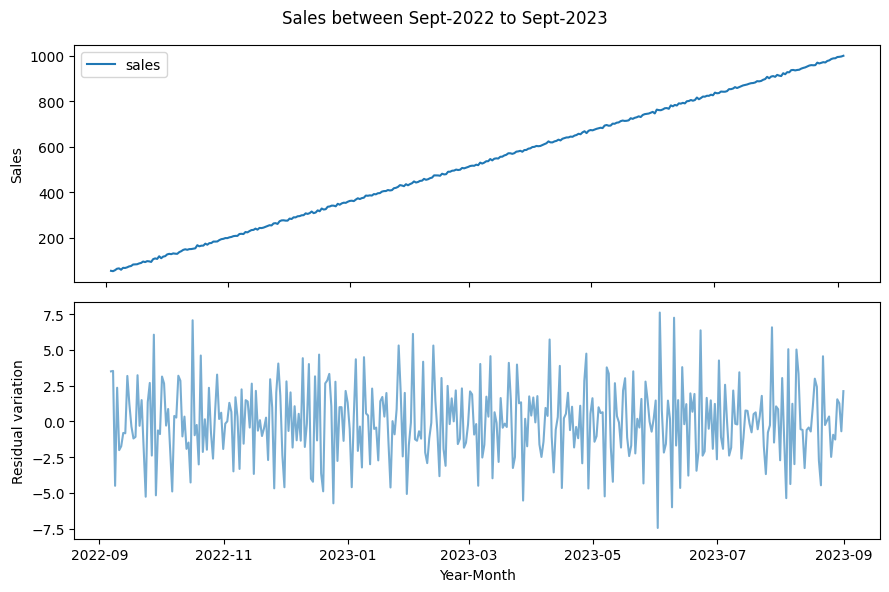

In [474]:
residual = decomp.resid #obtaining variability

#Creating the plot:
fig, axis= plt.subplots(2,1, figsize =(9,6))

sns.lineplot(sales_raw, ax=axis[0])

sns.lineplot(residual, alpha=0.6, ax=axis[1])

axis[0].set_xticklabels('')
axis[0].set_ylabel('Sales')
axis[1].set_ylabel('Residual variation')

axis[0].set_xlabel('')
axis[1].set_xlabel('Year-Month')

plt.suptitle('Sales between Sept-2022 to Sept-2023')
plt.tight_layout()
plt.show()

## Autocorrelation analysis

The autocorrelation analysis suggests that sales data observations are highly correlated over time. Even though the autocorrelation declines over time, it remains still high

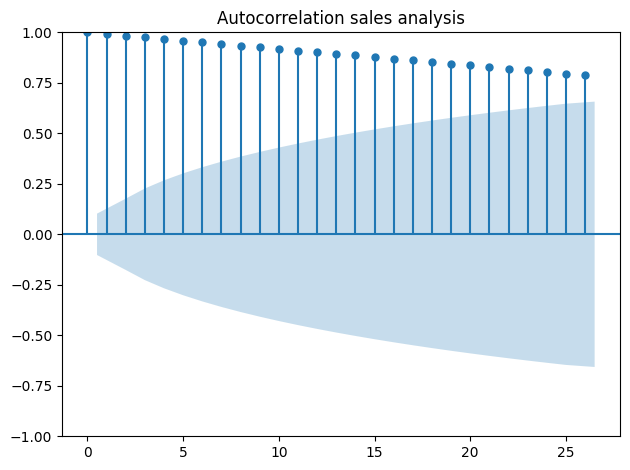

In [475]:
plot_acf(sales_raw)

plt.title('Autocorrelation sales analysis')
plt.tight_layout()

plt.show()

# Splitting data into train and test

After studying the time series features of sales data, the next step is to split the data to train the ARIMA machine model

For this step, splititng the data will be a little bit different process. The train_test_split by default suffles the data before splitting, meaning that test and train would have data combined for different months of the year. This is not result needed if the goal is to train an ARIMA model. 

The test data to assess the ARIMA model should correspond to the most recent data of sales so that I can assess model performance based on how predictions of recent sales data differ from the actual most recent sales.

In [476]:
# Here I am just confirming that data is sorted by date:
print(sales_raw.index.is_monotonic_increasing)


True


Here I am setting the size of the training set, which is equal to 80% of the whole data:

In [477]:
train_size = int(0.8 * len(sales_raw)) 

Now, when splitting data, the test_size argument will be equalt to the total observations minus the number of observations of the train data 'train_size'

In [478]:
X_train, X_test = train_test_split(sales_raw, shuffle=False, test_size=len(sales_raw)-train_size, random_state=42)

In [479]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 292 entries, 2022-09-03 17:10:08.079328 to 2023-06-21 17:10:08.079328
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sales   292 non-null    float64
dtypes: float64(1)
memory usage: 4.6 KB


In [480]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 74 entries, 2023-06-22 17:10:08.079328 to 2023-09-03 17:10:08.079328
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sales   74 non-null     float64
dtypes: float64(1)
memory usage: 1.2 KB


Storing datasets:

In [481]:
X_train.to_csv('/workspaces/ARIMA_Sales_Forceasting/data/processed/X_train', index=True ,index_label='date')
X_test.to_csv('//workspaces/ARIMA_Sales_Forceasting/data/processed/X_test', index=True, index_label='date')

# Training the ARIMA (AutoRegressive Integrated Moving Average) model 

## Opening data:

In [482]:
X_train=pd.read_csv('/workspaces/ARIMA_Sales_Forceasting/data/processed/X_train', index_col='date')
X_test=pd.read_csv('//workspaces/ARIMA_Sales_Forceasting/data/processed/X_test', index_col='date')

In [483]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 292 entries, 2022-09-03 17:10:08.079328 to 2023-06-21 17:10:08.079328
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sales   292 non-null    float64
dtypes: float64(1)
memory usage: 4.6+ KB


In [484]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74 entries, 2023-06-22 17:10:08.079328 to 2023-09-03 17:10:08.079328
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sales   74 non-null     float64
dtypes: float64(1)
memory usage: 1.2+ KB


## Transforming data into stationary

In [485]:
X_train_st = X_train.diff().dropna()
X_test_st = X_test.diff().dropna()

Both stationary tests performed to train and test data suggest that with a 99% confidence, sales data is stationary

In [486]:
adf_test(X_train_st)
adf_test(X_test_st)

Results of Dickey-Fuller Test:
Test Statistic                -1.268120e+01
p-value                        1.185940e-23
#Lags Used                     6.000000e+00
Number of Observations Used    2.840000e+02
Critical Value (1%)           -3.453587e+00
Critical Value (5%)           -2.871771e+00
Critical Value (10%)          -2.572222e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                 -4.807242
p-value                         0.000053
#Lags Used                     11.000000
Number of Observations Used    61.000000
Critical Value (1%)            -3.542413
Critical Value (5%)            -2.910236
Critical Value (10%)           -2.592745
dtype: float64


## Estimating ARIMA model

In [487]:
#model = auto_arima(X_train_st, seasonal = True, trace = True, m = 7)
model = auto_arima(X_train, seasonal = False, trace = True, m = 7)

Performing stepwise search to minimize aic


/home/vscode/.local/lib/python3.11/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (7) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.82 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1675.428, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1578.564, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1475.165, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1763.761, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1475.512, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1475.495, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1479.028, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1762.924, Time=0.12 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 1.674 seconds


In [488]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  292
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -734.582
Date:                Fri, 15 Dec 2023   AIC                           1475.165
Time:                        19:53:55   BIC                           1486.185
Sample:                    09-03-2022   HQIC                          1479.579
                         - 06-21-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.5984      0.011    243.641      0.000       2.577       2.619
ma.L1         -0.9439      0.021    -44.117      0.000      -0.986      -0.902
sigma2         9.0537      0.817     11.084      0.000       7.453      10.655
===================================================================================
Ljung-Box (L1) (Q):                   1.34   Jarque-Bera (JB):                 1.24
Prob(Q):                              0.25   Prob(JB):                         0.54
Heteroskedasticity (H):               0.95   Skew:                             0.06
Prob(H) (two-sided):                  0.81   Kurtosis:                         2.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Evaluating model performance:

Making a prediction to contrast it with actual test data:

In [489]:
#forecast = pd.DataFrame(model.predict(len(X_test_st)), columns=['sales'])
forecast = pd.DataFrame(model.predict(len(X_test)), columns=['sales'])

In [490]:
forecast.head()

,sales
2023-06-22 17:10:08.079328,810.107776
2023-06-23 17:10:08.079328,812.706154
2023-06-24 17:10:08.079328,815.304531
2023-06-25 17:10:08.079328,817.902909
2023-06-26 17:10:08.079328,820.501287


In [491]:
X_test_st.head()

,sales
date,
2023-06-23 17:10:08.079328,-7.489058
2023-06-24 17:10:08.079328,5.374938
2023-06-25 17:10:08.079328,6.421263
2023-06-26 17:10:08.079328,-0.514759
2023-06-27 17:10:08.079328,4.058426


In [492]:
# X_test_st.reset_index(inplace=True, col_fill='date')
# X_test_st.date=pd.to_datetime(X_test_st.date, errors='raise', yearfirst=True)
# X_test_st = X_test_st.set_index("date")


X_test.reset_index(inplace=True, col_fill='date')
X_test.date=pd.to_datetime(X_test.date, errors='raise', yearfirst=True)
X_test = X_test.set_index("date")

# forecast.reset_index(inplace=True, col_fill='index')
# forecast.reset_index(inplace=True)
# forecast.index=pd.to_datetime(forecast.index, errors='raise', yearfirst=True)


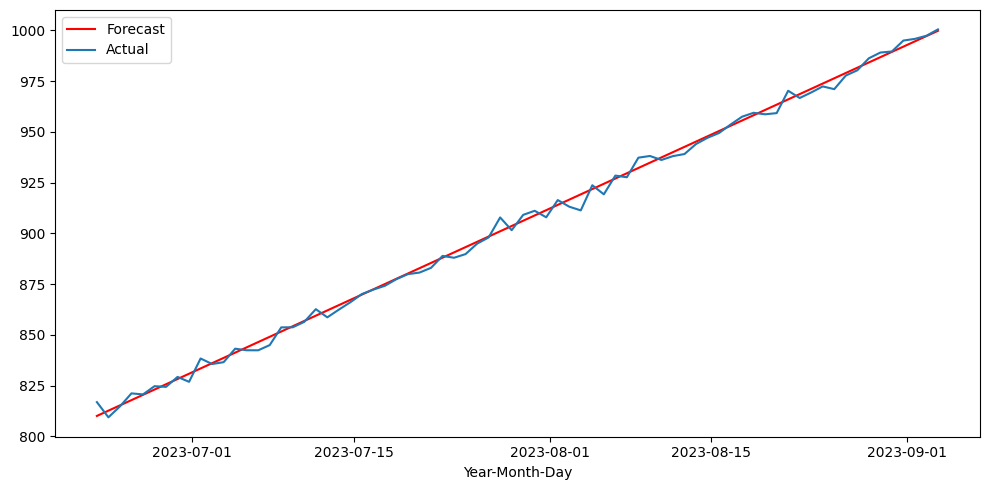

In [498]:
fig, axis = plt.subplots(figsize=(10, 5))

plt.plot(forecast, color='red', label='Forecast')
plt.plot(X_test, label='Actual')

axis.set_xlabel('Year-Month-Day')

plt.legend()
plt.tight_layout()

plt.show()